# Event detection

First we use some simple event detection algorithm, such as detecting when there is a corner or a straight line.

Later on we could use Wavelets and the segmented signal to detect common patterns.

In [1]:
import pandas as pd
import dask.dataframe as dd
import numpy as np

from pprint import pprint
from IPython.display import display
from typing import Dict, Union, List, Callable
from pathlib import Path

import lib.util
import lib.data_preparation
import lib.event_detection

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

sns.set_style('darkgrid')
sns.set_context('notebook')

pd.set_option('max_columns', None)

In [2]:
folderpath = Path('data/UAH-DRIVESET-v1/')

In [3]:
df = dd.read_parquet(Path(folderpath, 'data_process.parquet'))

df = lib.util.repartition_by(df.set_index('trip', drop=False))

df = df.map_partitions(lambda x: x.set_index('timestamp', drop=True).sort_index())

# Sequence cutting

First a manual and human made approach. We use some empiric criteria to detect either we are in a straight line or a corner. We will add some criteria for the time spent between events (like no need to have 2 really close events, better to fuse them).
Then the event will be labeled.

Later another more statistical approach with Wavelets could be tried...

## Empiric approach

First we define the straight-line as a driver in a highway not touching his steering wheel for at least 2 seconds.

As such we can define what is the approximate vehicle movement when there is no driver interaction.

Then we can define
* corner as the moment the driver act for the vehicle to turn (so opposite to what is said before)
* straight line as above

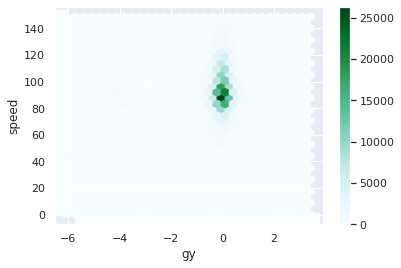

In [4]:
df.compute().plot.hexbin(x='gy', y='speed', gridsize=30, marginals=True, sharex=False)

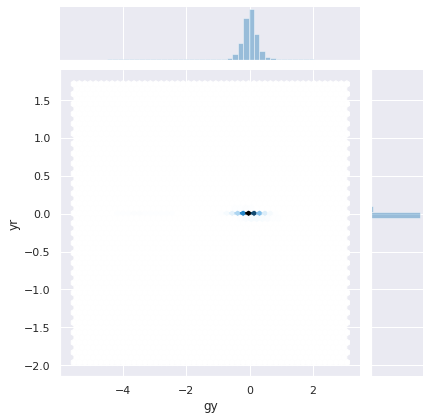

In [5]:
sns.jointplot(
    x='gy',
    y='yr',
    data=df.loc[(df['speed'] > 100) & (abs(df['yr']) < 2)].compute(),
    kind='hex'
)

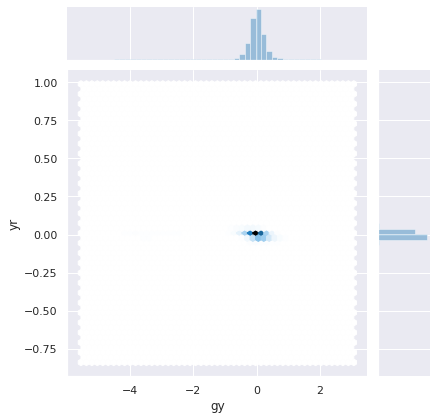

In [6]:
sns.jointplot(
    x='gy',
    y='yr',
    data=df.loc[(df['speed'] > 100) & (abs(df['yr']) < 1)].compute(),
    kind='hex'
)

As an empiric rule we can take as thresholds:
- gy > 0.5 m/s2
Usually we would use the Yaw Rate too, but the data seems unreliable
if below, the driver is trying to keep a straight-line, if higher he goes into a corner

In [7]:
df['corner_flag'] = (df['gy'].abs() > 0.3)
df['straight_flag'] = (df['gy'].abs() < 0.5) & (df['speed'] > 10)

In [8]:
df['dtime'] = df['time'].map_partitions(lambda x: x.diff().fillna(0))

We use a few partitions as a test dataframe (and computed to pd.DataFrame)

In [9]:
dft = df.partitions[-2:].compute()

### Event merging
We have to add a condition between events such as they are not too close, or else they are merged.
This is valid in-between corner, if there is 1s between 2 corners, we consider it to be 1. 1s is chosen as an empiric value for maximum driver reaction.

In [10]:
corner = lib.event_detection.calculate(
        inside_flag=dft['corner_flag'], 
        outside=dft['dtime'],
        outside_cond=lambda x: x.sum() < 1
)
display(corner.sum())

2206089

### Hashing
We have our own made hash function which can avoid event count ID collision.
We also have a hash function which calculate an hash integer from pandas own library

In [11]:
for method in ['custom', 0]:
    corner_hash = lib.event_detection.make_hash(
        corner,
        dft['trip'],
        dft['time'].astype(str).map(lambda x: x[-2:]),
        method=method
    )
    display(corner_hash.unique())
    display(corner_hash.to_frame().memory_usage(deep=True))

[NaN, 26km-D6-AGGRESSIVE-MOTORWAY1x47, 26km-D6-AGGRESSIVE-MOTORWAY2x97, 26km-D6-AGGRESSIVE-MOTORWAY3x47, 26km-D6-AGGRESSIVE-MOTORWAY4x27, ..., 26km-D6-NORMAL-MOTORWAY351x97, 26km-D6-NORMAL-MOTORWAY352x57, 26km-D6-NORMAL-MOTORWAY353x57, 26km-D6-NORMAL-MOTORWAY354x97, 26km-D6-NORMAL-MOTORWAY355x77]
Length: 356
Categories (355, object): [26km-D6-AGGRESSIVE-MOTORWAY1x47, 26km-D6-AGGRESSIVE-MOTORWAY2x97, 26km-D6-AGGRESSIVE-MOTORWAY3x47, 26km-D6-AGGRESSIVE-MOTORWAY4x27, ..., 26km-D6-NORMAL-MOTORWAY352x57, 26km-D6-NORMAL-MOTORWAY353x57, 26km-D6-NORMAL-MOTORWAY354x97, 26km-D6-NORMAL-MOTORWAY355x77]

Index    810968
0         80188
dtype: int64

[18446744073709551615, 15826349013414622461, 13083262382229523560, 85587143439226155, 17945603001928085723, ..., 8865844034968968519, 540978102180248227, 13630003249296081565, 1679548564237198955, 12303196061447971297]
Length: 356
Categories (356, uint64): [18446744073709551615, 15826349013414622461, 13083262382229523560, 85587143439226155, ..., 540978102180248227, 13630003249296081565, 1679548564237198955, 12303196061447971297]

Index    810968
0         51990
dtype: int64

All in one now

In [12]:
dft['corner_event'] = lib.event_detection.detect(
    data=dft,
    inside_flag='corner_flag',
    outside='dtime',
    outside_cond=lambda x: x.sum() < 1
)

display(dft['corner_event'].head())

dft['straight_event'] = lib.event_detection.detect(
    data=dft,
    inside_flag='straight_flag',
    outside='dtime',
    outside_cond=lambda x: x.sum() < 1,
)

display(dft['straight_event'].head())

display(dft.head())

timestamp
2015-12-21 12:01:00.170                                NaN
2015-12-21 12:01:00.270                                NaN
2015-12-21 12:01:00.370                                NaN
2015-12-21 12:01:00.470    26km-D6-AGGRESSIVE-MOTORWAY1x47
2015-12-21 12:01:00.570    26km-D6-AGGRESSIVE-MOTORWAY1x47
Name: corner_event, dtype: category
Categories (355, object): [26km-D6-AGGRESSIVE-MOTORWAY100x17, 26km-D6-AGGRESSIVE-MOTORWAY101x47, 26km-D6-AGGRESSIVE-MOTORWAY102x47, 26km-D6-AGGRESSIVE-MOTORWAY103x27, ..., 26km-D6-NORMAL-MOTORWAY352x57, 26km-D6-NORMAL-MOTORWAY353x57, 26km-D6-NORMAL-MOTORWAY354x97, 26km-D6-NORMAL-MOTORWAY355x77]

timestamp
2015-12-21 12:01:00.170    NaN
2015-12-21 12:01:00.270    NaN
2015-12-21 12:01:00.370    NaN
2015-12-21 12:01:00.470    NaN
2015-12-21 12:01:00.570    NaN
Name: straight_event, dtype: category
Categories (49, object): [26km-D6-AGGRESSIVE-MOTORWAY10x97, 26km-D6-AGGRESSIVE-MOTORWAY11x87, 26km-D6-AGGRESSIVE-MOTORWAY12x67, 26km-D6-AGGRESSIVE-MOTORWAY13x97, ..., 26km-D6-NORMAL-MOTORWAY46x37, 26km-D6-NORMAL-MOTORWAY47x97, 26km-D6-NORMAL-MOTORWAY48x57, 26km-D6-NORMAL-MOTORWAY49x27]

,time_gps,latitude,longitude,altitude,vertical accuracy,horizontal accuracy,course,difcourse: course variation,position state,lanex dist state,lanex history,path,trip_gps,time_osm,current road maxspeed,maxspeed reliability,road type,# of lanes in road,estimated current lane,latitude used to query osm,longitude used to query osm,delay answer osm query,trip_osm,time,above 50kph,gx,gy,gz,gx_filt,gy_filt,gz_filt,roll,pitch,yaw,trip,speed,yr,beta,vx,vy,curvature,distx,disty,distance,change_points,corner_flag,straight_flag,dtime,corner_event,straight_event
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-12-21 12:01:00.170,10.07,40.505707,-3.355475,602.1,3.0,5.0,274.2,0.703,0.0,0.0,0.0,20151221120051-26km-D6-AGGRESSIVE-MOTORWAY,26km-D6-AGGRESSIVE-MOTORWAY,13.18,120.0,1.0,motorway,3.0,-1.0,40.505737,-3.355892,1.124,26km-D6-AGGRESSIVE-MOTORWAY,1.450699e+09,1.0,-1.068062,-0.193536,-1.16739,-0.032,-0.019,-0.042,-1.575301,-0.008937,-0.030091,26km-D6-AGGRESSIVE-MOTORWAY,62.9,-0.016322,-0.188559,17.472128,-0.057500,-61335.098109,0.000000,0.000000,0.000000,False,False,True,0.0,NaN,NaN
2015-12-21 12:01:00.270,10.07,40.505707,-3.355475,602.1,3.0,5.0,274.2,0.703,0.0,0.0,0.0,20151221120051-26km-D6-AGGRESSIVE-MOTORWAY,26km-D6-AGGRESSIVE-MOTORWAY,13.18,120.0,1.0,motorway,3.0,-1.0,40.505737,-3.355892,1.124,26km-D6-AGGRESSIVE-MOTORWAY,1.450699e+09,1.0,-0.490509,-0.028541,0.12753,-0.062,-0.016,-0.041,-1.582708,-0.007024,-0.031723,26km-D6-AGGRESSIVE-MOTORWAY,62.9,-0.015865,-0.023703,17.472221,-0.007228,-63100.337114,1.747214,-0.004179,1.747221,False,False,True,0.1,NaN,NaN
2015-12-21 12:01:00.370,10.07,40.505707,-3.355475,602.1,3.0,5.0,274.2,0.703,0.0,0.0,0.0,20151221120051-26km-D6-AGGRESSIVE-MOTORWAY,26km-D6-AGGRESSIVE-MOTORWAY,13.18,120.0,1.0,motorway,3.0,-1.0,40.505737,-3.355892,1.124,26km-D6-AGGRESSIVE-MOTORWAY,1.450699e+09,1.0,-0.135454,0.110377,0.83385,-0.014,-0.019,0.030,-1.586180,-0.006240,-0.033264,26km-D6-AGGRESSIVE-MOTORWAY,62.9,-0.015209,0.115015,17.472187,0.035073,-65821.515547,1.747219,0.000401,1.747221,False,False,True,0.1,NaN,NaN
2015-12-21 12:01:00.470,10.07,40.505707,-3.355475,602.1,3.0,5.0,274.2,0.703,0.0,0.0,0.0,20151221120051-26km-D6-AGGRESSIVE-MOTORWAY,26km-D6-AGGRESSIVE-MOTORWAY,13.18,120.0,1.0,motorway,3.0,-1.0,40.505737,-3.355892,1.124,26km-D6-AGGRESSIVE-MOTORWAY,1.450699e+09,1.0,-0.243488,0.321384,0.83385,-0.014,-0.019,0.030,-1.584695,-0.006845,-0.034765,26km-D6-AGGRESSIVE-MOTORWAY,62.9,-0.012788,0.325284,17.471941,0.099194,-78283.554553,1.747213,0.005676,1.747225,False,True,True,0.1,26km-D6-AGGRESSIVE-MOTORWAY1x47,NaN
2015-12-21 12:01:00.570,10.07,40.505707,-3.355475,602.1,3.0,5.0,274.2,0.703,0.0,0.0,0.0,20151221120051-26km-D6-AGGRESSIVE-MOTORWAY,26km-D6-AGGRESSIVE-MOTORWAY,13.18,120.0,1.0,motorway,3.0,-1.0,40.505737,-3.355892,1.124,26km-D6-AGGRESSIVE-MOTORWAY,1.450699e+09,1.0,0.012348,0.244245,-0.11772,-0.023,0.034,-0.002,-1.582302,-0.007752,-0.035821,26km-D6-AGGRESSIVE-MOTORWAY,62.9,-0.006427,0.246205,17.472061,0.075079,-155766.411684,1.747203,0.007637,1.747221,False,False,True,0.1,26km-D6-AGGRESSIVE-MOTORWAY1x47,NaN


# Test and feedback

Let's review the empiric events and plot per trip

One important thing is that whathever hash was chosen, all of the rest rely on the following fact:

    The no event are labeled with a value which is interpreted as a False Boolean, for example:
        bool(np.NaN) == False
        bool(0) == False

In [13]:
dft = df.partitions[-1:].compute()

df['corner_flag'] = df['gy'].abs() > 0.3
df['straight_flag'] = (df['gy'].abs() < 0.5) & (df['speed'] > 10)

dft['corner_event'] = lib.event_detection.detect(
    data=dft,
    inside_flag='corner_flag',
    outside='dtime',
    outside_cond=lambda x: x.sum() < 1
)
display(f"{dft['corner_event'].unique().shape[0]} corner events")

dft['straight_event'] = lib.event_detection.detect(
    data=dft,
    inside_flag='straight_flag',
    outside='dtime',
    outside_cond=lambda x: x.sum() < 1
)
display(f"{dft['straight_event'].unique().shape[0]} straight events")

'200 corner events'

'14 straight events'

In [14]:
dft_plot_gps = dft[['longitude', 'latitude', 'straight_event', 'corner_event']]\
                  .resample('10s')\
                  .agg(lib.util.agg_num_and_obj)
display(dft_plot_gps.head())

,longitude,latitude,straight_event,corner_event
timestamp,,,,
2015-12-17 16:27:10,-3.359361,40.505922,NaN,26km-D6-NORMAL-MOTORWAY2x17
2015-12-17 16:27:20,-3.359361,40.505922,NaN,26km-D6-NORMAL-MOTORWAY2x17
2015-12-17 16:27:30,-3.360151,40.505753,NaN,26km-D6-NORMAL-MOTORWAY5x27
2015-12-17 16:27:40,-3.362715,40.505206,NaN,26km-D6-NORMAL-MOTORWAY5x27
2015-12-17 16:27:50,-3.365347,40.504643,26km-D6-NORMAL-MOTORWAY1x37,26km-D6-NORMAL-MOTORWAY5x27


In [15]:
lib.event_detection.plot_gps_marked(df=dft_plot_gps,event='corner_event')

In [16]:
lib.event_detection.plot_gps_marked(df=dft_plot_gps,event='straight_event')

## Event Selection
You can exclude the short straight event too

In [17]:
ix_short_event = dft['dtime'].groupby(dft['straight_event']).sum() < 3
display(ix_short_event)
display(ix_short_event[ix_short_event].index)

dft['straight_event_long'] = lib.event_detection.delete_event(
    dft['straight_event'],
    event_bool=ix_short_event
)
display(dft['straight_event_long'])

straight_event
26km-D6-NORMAL-MOTORWAY10x37    False
26km-D6-NORMAL-MOTORWAY11x97     True
26km-D6-NORMAL-MOTORWAY12x57    False
26km-D6-NORMAL-MOTORWAY13x27    False
26km-D6-NORMAL-MOTORWAY1x37     False
26km-D6-NORMAL-MOTORWAY2x67     False
26km-D6-NORMAL-MOTORWAY3x47     False
26km-D6-NORMAL-MOTORWAY4x07     False
26km-D6-NORMAL-MOTORWAY5x37      True
26km-D6-NORMAL-MOTORWAY6x77     False
26km-D6-NORMAL-MOTORWAY7x67     False
26km-D6-NORMAL-MOTORWAY8x07     False
26km-D6-NORMAL-MOTORWAY9x07      True
Name: dtime, dtype: bool

CategoricalIndex(['26km-D6-NORMAL-MOTORWAY11x97',
                  '26km-D6-NORMAL-MOTORWAY5x37',
                  '26km-D6-NORMAL-MOTORWAY9x07'],
                 categories=['26km-D6-NORMAL-MOTORWAY10x37', '26km-D6-NORMAL-MOTORWAY11x97', '26km-D6-NORMAL-MOTORWAY12x57', '26km-D6-NORMAL-MOTORWAY13x27', '26km-D6-NORMAL-MOTORWAY1x37', '26km-D6-NORMAL-MOTORWAY2x67', '26km-D6-NORMAL-MOTORWAY3x47', '26km-D6-NORMAL-MOTORWAY4x07', ...], ordered=False, name='straight_event', dtype='category')

timestamp
2015-12-17 16:27:14.070                             NaN
2015-12-17 16:27:14.170                             NaN
2015-12-17 16:27:14.270                             NaN
2015-12-17 16:27:14.370                             NaN
2015-12-17 16:27:14.470                             NaN
                                       ...             
2015-12-17 16:44:23.070    26km-D6-NORMAL-MOTORWAY13x27
2015-12-17 16:44:23.170    26km-D6-NORMAL-MOTORWAY13x27
2015-12-17 16:44:23.270    26km-D6-NORMAL-MOTORWAY13x27
2015-12-17 16:44:23.370    26km-D6-NORMAL-MOTORWAY13x27
2015-12-17 16:44:23.470    26km-D6-NORMAL-MOTORWAY13x27
Name: straight_event_long, Length: 10295, dtype: category
Categories (10, object): [26km-D6-NORMAL-MOTORWAY10x37, 26km-D6-NORMAL-MOTORWAY12x57, 26km-D6-NORMAL-MOTORWAY13x27, 26km-D6-NORMAL-MOTORWAY1x37, ..., 26km-D6-NORMAL-MOTORWAY4x07, 26km-D6-NORMAL-MOTORWAY6x77, 26km-D6-NORMAL-MOTORWAY7x67, 26km-D6-NORMAL-MOTORWAY8x07]

In [18]:
dft['corner_event_long'] = lib.event_detection.delete_event(
    dft['corner_event'],
    event_bool=dft['dtime'].groupby(dft['corner_event']).sum() < 3
)
display(dft['corner_event_long'])

timestamp
2015-12-17 16:27:14.070    NaN
2015-12-17 16:27:14.170    NaN
2015-12-17 16:27:14.270    NaN
2015-12-17 16:27:14.370    NaN
2015-12-17 16:27:14.470    NaN
                          ... 
2015-12-17 16:44:23.070    NaN
2015-12-17 16:44:23.170    NaN
2015-12-17 16:44:23.270    NaN
2015-12-17 16:44:23.370    NaN
2015-12-17 16:44:23.470    NaN
Name: corner_event_long, Length: 10295, dtype: category
Categories (72, object): [26km-D6-NORMAL-MOTORWAY101x27, 26km-D6-NORMAL-MOTORWAY103x57, 26km-D6-NORMAL-MOTORWAY104x77, 26km-D6-NORMAL-MOTORWAY106x77, ..., 26km-D6-NORMAL-MOTORWAY91x07, 26km-D6-NORMAL-MOTORWAY94x97, 26km-D6-NORMAL-MOTORWAY95x77, 26km-D6-NORMAL-MOTORWAY98x97]

In [19]:
dft_plot_gps = dft[['longitude', 'latitude', 'straight_event_long', 'corner_event_long']]\
                  .resample('1s')\
                  .agg(lib.util.agg_num_and_obj)
display(lib.event_detection.plot_gps_marked(df=dft_plot_gps,event='straight_event_long'))
display(lib.event_detection.plot_gps_marked(df=dft_plot_gps,event='corner_event_long'))

Ok that's good for me !

Let's apply to all the data now !

## Apply to complete dataset

In [20]:
df = dd.read_parquet(Path(folderpath, 'data_process.parquet'))

df = lib.util.repartition_by(df.set_index('trip', drop=False))

df = df.map_partitions(lambda x: x.set_index('timestamp', drop=True).sort_index())

In [21]:
df_event = df.map_partitions(
    lib.event_detection.apply_corner_and_straight_event
)

display(df_event.head())

,time_gps,latitude,longitude,altitude,vertical accuracy,horizontal accuracy,course,difcourse: course variation,position state,lanex dist state,lanex history,path,trip_gps,time_osm,current road maxspeed,maxspeed reliability,road type,# of lanes in road,estimated current lane,latitude used to query osm,longitude used to query osm,delay answer osm query,trip_osm,time,above 50kph,gx,gy,gz,gx_filt,gy_filt,gz_filt,roll,pitch,yaw,trip,speed,yr,beta,vx,vy,curvature,distx,disty,distance,change_points,dtime,corner_flag,straight_flag,corner_event,straight_event
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-12-11 16:56:19.910,27.95,40.533794,-3.456321,650.5,6.0,5.0,269.6,0.352,0.0,0.0,0.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,34.87,90.0,1.0,primary,2.0,1.0,40.533775,-3.458919,1.017,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,0.107936,-0.041451,-0.39240,-0.006,-0.009,-0.022,-1.561743,0.011128,0.097137,12km-D5-AGGRESSIVE-SECONDARY,131.878207,0.004842,-0.044547,36.632824,-0.028482,433436.793932,0.000000,0.000000,0.000000,False,0.0,False,True,NaN,NaN
2015-12-11 16:56:20.010,27.95,40.533794,-3.456321,650.5,6.0,5.0,269.6,0.352,0.0,0.0,0.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,34.87,90.0,1.0,primary,2.0,1.0,40.533775,-3.458919,1.017,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,0.186017,-0.053898,-0.36297,-0.002,-0.006,-0.034,-1.561573,0.013535,0.097621,12km-D5-AGGRESSIVE-SECONDARY,131.878207,0.005547,-0.057444,36.632817,-0.036728,378370.393667,3.663279,0.002966,3.663280,False,0.1,False,True,NaN,NaN
2015-12-11 16:56:20.110,27.95,40.533794,-3.456321,650.5,6.0,5.0,269.6,0.352,0.0,0.0,0.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,34.87,90.0,1.0,primary,2.0,1.0,40.533775,-3.458919,1.017,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,0.213286,-0.044389,-0.12753,0.011,-0.010,-0.021,-1.560896,0.015397,0.098246,12km-D5-AGGRESSIVE-SECONDARY,131.878207,0.006464,-0.048522,36.632822,-0.031023,324710.369281,3.663279,0.002874,3.663280,False,0.1,False,True,NaN,NaN
2015-12-11 16:56:20.210,27.95,40.533794,-3.456321,650.5,6.0,5.0,269.6,0.352,0.0,0.0,0.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,34.87,90.0,1.0,primary,2.0,1.0,40.533775,-3.458919,1.017,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,0.229753,0.008214,-0.40221,0.023,-0.002,-0.031,-1.559989,0.016346,0.098914,12km-D5-AGGRESSIVE-SECONDARY,131.878207,0.008321,0.002894,36.632835,0.001850,252239.921285,3.663285,0.004844,3.663289,False,0.1,False,True,NaN,NaN
2015-12-11 16:56:20.310,27.95,40.533794,-3.456321,650.5,6.0,5.0,269.6,0.352,0.0,0.0,0.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,34.87,90.0,1.0,primary,2.0,1.0,40.533775,-3.458919,1.017,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,0.132273,-0.010419,-0.40221,0.023,-0.002,-0.031,-1.557711,0.017944,0.099910,12km-D5-AGGRESSIVE-SECONDARY,131.878207,0.009965,-0.016791,36.632834,-0.010735,210630.254921,3.663275,0.005912,3.663280,False,0.1,False,True,NaN,NaN


In [22]:
df_event[['straight_event', 'corner_event']].describe().compute()

,straight_event,corner_event
unique,302,999
count,274540,65092
top,25km-D4-NORMAL-MOTORWAY7x.6,25km-D5-AGGRESSIVE-MOTORWAY83x81
freq,5069,423


In [23]:
df_event.to_parquet(Path(folderpath, 'data_event.parquet'))